## Libraries and requirements

In [ ]:
!pip install pyswarm -q

  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import logging
import time
import numpy as np
import tensorflow as tf
from pyswarm import pso
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from sklearn.metrics import pairwise_distances_argmin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

from helix_optimizer import HelixMotion, helix_optimizer, HelixSGOptimizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Adafactor
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

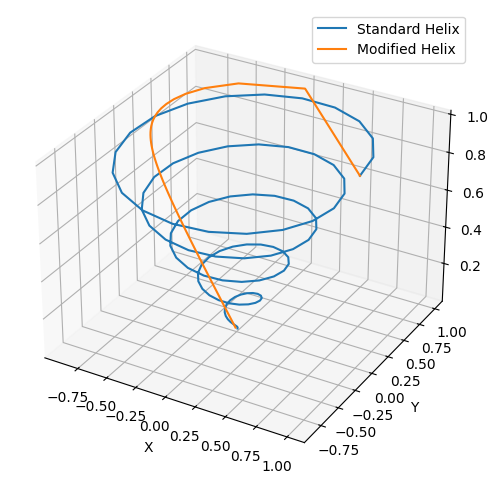

In [ ]:
# Create an instance of the HelixMotion class
helix = HelixMotion(x0=0, y0=0, z0=1, steps=100, radius=1, depth_target=0)

# Generate trajectories
standard_trajectory = helix.standard_helix()
modified_trajectory = helix.modified_helix()

# Plot the trajectories
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Standard helix
ax.plot(standard_trajectory[:, 0], standard_trajectory[:, 1], standard_trajectory[:, 2], label='Standard Helix')

# Modified helix
ax.plot(modified_trajectory[:, 0], modified_trajectory[:, 1], modified_trajectory[:, 2], label='Modified Helix')

# Configure plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

## Quadratic Noisy dataset

In [ ]:
# Define a simple neural network model
class SimpleNN(tf.keras.Model):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(64, activation="relu")
        self.layer2 = tf.keras.layers.Dense(32, activation="relu")
        self.layer3 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)

# Loss function
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Generate datasets for training
def generate_datasets():
    x_train = np.linspace(-2, 2, 100).reshape(-1, 1)
    y_train_quadratic = x_train**2
    y_train_noisy = y_train_quadratic + np.random.normal(0, 0.1, size=x_train.shape)
    y_train_linear = 2 * x_train + 1
    return (x_train, y_train_quadratic, y_train_noisy, y_train_linear)


# Train the model using different optimizers
def train_model(helix_motion, optimizer_type, x_train, y_train, steps=1000):
    model = SimpleNN()
    losses = []

    for step in range(steps):
        with tf.GradientTape() as tape:
            y_pred = model(x_train)
            loss = loss_function(y_train, y_pred)
            losses.append(loss.numpy())

        grads = tape.gradient(loss, model.trainable_variables)

        if optimizer_type == "helix":
            for i, grad in enumerate(grads):
                helix_move = helix_motion.helix_optimizer(step)
                scaled_helix_move = helix_move[0] * 0.1
                if np.all(np.isfinite(grad.numpy())):
                    model.trainable_variables[i].assign_add(
                        scaled_helix_move * grad.numpy()
                    )
        else:
            optimizer_instance = optimizer_type(learning_rate=0.01)
            optimizer_instance.apply_gradients(zip(grads, model.trainable_variables))

        if step % 100 == 0:
            print(
                f"Optimizer: {str(optimizer_type).split('.')[-1]}, "
                f"Step: {step}/{steps}, Loss: {loss.numpy()}"
            )

    return losses

In [ ]:
if __name__ == "__main__":
    # Create datasets
    datasets = generate_datasets()
    optimizers = ["helix", tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
    dataset_names = ["Quadratic", "Noisy Quadratic"]

    # Initialize the HelixMotion object
    helix_motion = HelixMotion(radius=1, depth_target=0, steps=1000)
    benchmark_results = []

    # Train models with different optimizers
    for i, (x_train, y_train) in enumerate(zip(datasets[::2], datasets[1::2])):
        for optimizer in optimizers:
            print(f"Training on {dataset_names[i]} with {str(optimizer).split('.')[-1]} optimizer...")
            losses = train_model(helix_motion, optimizer, x_train, y_train, steps=1000)
            benchmark_results.append({
                "Dataset": dataset_names[i],
                "Optimizer": str(optimizer).split(".")[-1],
                "Final Loss": losses[-1],
                "Losses": losses,
            })

    # Create a DataFrame for results
    df_benchmark = pd.DataFrame(benchmark_results)
    print(df_benchmark)

    # Plot loss curves
    for i, (x_train, y_train) in enumerate(zip(datasets[::2], datasets[1::2])):
        plt.figure(figsize=(12, 8))
        for optimizer in optimizers:
            losses = train_model(helix_motion, optimizer, x_train, y_train, steps=1000)
            plt.plot(losses, label=f"{str(optimizer).split('.')[-1]}")
        plt.title(f"Loss Curves for {dataset_names[i]} Dataset")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # Bar plot for benchmark results
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Dataset", y="Final Loss", hue="Optimizer", data=df_benchmark)
    plt.title("Final Loss Comparison Across Datasets and Optimizers")
    plt.show()

## Boston dataset

In [ ]:
# Define the loss function (MSE)
def loss_function(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define a simple neural network model
class SimpleNN(tf.keras.Model):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(64, activation="relu")
        self.layer2 = tf.keras.layers.Dense(32, activation="relu")
        self.layer3 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)


# Load and preprocess the Boston Housing dataset
def load_and_preprocess_data():
    # Load the Boston Housing dataset
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.2, random_state=42
    )

    # Normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test


# Train the model using different optimizers
def train_model(helix_motion, optimizer_type, X_train, y_train, steps=1000):
    model = SimpleNN()
    losses = []

    for step in range(steps):
        with tf.GradientTape() as tape:
            y_pred = model(X_train)
            loss = loss_function(y_train, y_pred)
            losses.append(loss.numpy())

        grads = tape.gradient(loss, model.trainable_variables)

        if optimizer_type == "helix":
            for i, grad in enumerate(grads):
                helix_move = helix_motion.helix_optimizer(step)
                scaled_helix_move = helix_move[0] * 0.1
                if np.all(np.isfinite(grad.numpy())):
                    model.trainable_variables[i].assign_add(
                        scaled_helix_move * grad.numpy()   )
        else:
            optimizer_instance = optimizer_type(learning_rate=0.01)
            optimizer_instance.apply_gradients(zip(grads, model.trainable_variables))

        if step % 100 == 0:
            print(
                f"Optimizer: {str(optimizer_type).split('.')[-1]}, "
                f"Step: {step}/{steps}, Loss: {loss.numpy()}"
            )

    return losses

In [ ]:
if __name__ == "__main__":
    # Load the dataset
    X_train, y_train, X_test, y_test = load_and_preprocess_data()

    # Initialize the HelixMotion object
    helix_motion = HelixMotion(radius=1, depth_target=0, steps=1000)

    # List of optimizers to test
    optimizers = ["helix", tf.keras.optimizers.Adam, tf.keras.optimizers.SGD]
    # Initialize a dataframe to store results
    benchmark_results = []

    # Train models with different optimizers
    for optimizer in optimizers:
        print(f"Training with {str(optimizer).split('.')[-1]} optimizer...")
        losses = train_model(
            helix_motion if optimizer == "helix" else None, optimizer, X_train, y_train
        )
        benchmark_results.append(
            {
                "Optimizer": str(optimizer).split(".")[-1],
                "Final Loss": losses[-1],
                "Losses": losses,
            }
        )

    # Create a DataFrame for the results
    df_benchmark = pd.DataFrame(benchmark_results)
    print(df_benchmark)

    # Visualization: Bar plot for benchmark results
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Optimizer", y="Final Loss", data=df_benchmark)
    plt.title("Final Loss Comparison Across Optimizers")
    plt.show()

## Iris dataset

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin
from scipy.optimize import minimize
from pyswarm import pso
import matplotlib.pyplot as plt
from helix_optimizer import HelixMotion  # Import the HelixMotion class

# Load and normalize the Iris dataset
def load_and_prepare_iris():
    data = load_iris()
    features = data.data
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    return normalized_features

# Adam Optimizer for clustering
def adam_optimizer(data, k=3, lr=0.01, steps=200, beta1=0.9, beta2=0.999, epsilon=1e-8):
    feature_dim = data.shape[1]
    centroids = np.random.uniform(-2, 2, size=(k, feature_dim))
    m = np.zeros_like(centroids)
    v = np.zeros_like(centroids)

    for step in range(1, steps + 1):
        labels = pairwise_distances_argmin(data, centroids)
        grad = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                grad[i] = -2 * np.mean(cluster_points - centroids[i], axis=0)

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** step)
        v_hat = v / (1 - beta2 ** step)

        centroids -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    ssd = ssd_to_centroids(centroids.flatten(), data, k)
    return centroids, ssd


# Objective Function: Sum of Squared Distances (SSD) for Clustering
def ssd_to_centroids(centroids, data, k=3):
    centroids = centroids.reshape(k, -1)
    labels = pairwise_distances_argmin(data, centroids)
    ssd = 0
    for i in range(k):
        cluster_points = data[labels == i]
        ssd += np.sum((cluster_points - centroids[i]) ** 2)
    return ssd

# Clustering with HelixMotion (Loly Algorithm)
def test_helix_motion_iris(data, helix_motion, k=40, steps=2000):
    feature_dim = data.shape[1]
    initial_centroids = np.random.uniform(-2, 2, size=(k, feature_dim)).flatten()

    for step in range(steps):
        helix_move = helix_motion.helix_optimizer(step)
        initial_centroids += helix_move.flatten()

    final_centroids = initial_centroids.reshape(k, -1)
    ssd = ssd_to_centroids(final_centroids.flatten(), data, k)
    return final_centroids, ssd

# Gradient Descent for clustering
def test_gradient_descent_iris(data, k=3):
    feature_dim = data.shape[1]
    initial_centroids = np.random.uniform(-2, 2, size=(k, feature_dim)).flatten()
    result = minimize(ssd_to_centroids, initial_centroids, args=(data, k), method="BFGS")
    final_centroids = result.x.reshape(k, -1)
    return final_centroids, result.fun

# Particle Swarm Optimization (PSO) for clustering
def test_pso_iris(data, k=3):
    feature_dim = data.shape[1]
    lb = [-2] * (k * feature_dim)
    ub = [2] * (k * feature_dim)
    xopt, fopt = pso(ssd_to_centroids, lb, ub, args=(data, k))
    final_centroids = xopt.reshape(k, -1)
    return final_centroids, fopt

In [ ]:
# Main Execution
if __name__ == "__main__":
    data = load_and_prepare_iris()

    # Initialize HelixMotion
    helix_motion = HelixMotion(radius=0.5, depth_target=0, steps=2000)

    k = 2

    # Apply optimization algorithms
    helix_centroids, helix_ssd = test_helix_motion_iris(data, helix_motion, k)
    gd_centroids, gd_ssd = test_gradient_descent_iris(data, k)
    pso_centroids, pso_ssd = test_pso_iris(data, k)

    # Display results
    print("HelixMotion (Loly Algorithm) SSD:", helix_ssd)
    print("Gradient Descent SSD:", gd_ssd)
    print("PSO SSD:", pso_ssd)

    # Visualize SSD results
    plt.bar(
        ["HelixMotion", "Gradient Descent", "PSO"],
        [helix_ssd, gd_ssd, pso_ssd],
        color=["blue", "red", "green"],
    )
    plt.ylabel("Sum of Squared Distances (SSD)")
    plt.title("Comparison of Optimization Algorithms on Iris Dataset")
    plt.show()

In [ ]:
# Load and normalize the Iris dataset
def load_and_prepare_iris():
    data = load_iris()
    features = data.data
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)
    return normalized_features

# Objective Function: Sum of Squared Distances (SSD) for Clustering
def ssd_to_centroids(centroids, data, k=3):
    centroids = centroids.reshape(k, -1)  # Reshape into (k, feature_dim)
    labels = pairwise_distances_argmin(data, centroids)
    ssd = 0
    for i in range(k):
        cluster_points = data[labels == i]
        ssd += np.sum((cluster_points - centroids[i]) ** 2)
    return ssd

# Loly Algorithm using HelixMotion
def test_loly_motion_iris(data, k=3, steps=2000):
    feature_dim = data.shape[1]
    initial_centroids = np.random.uniform(-2, 2, size=(k, feature_dim)).flatten()
    helix = HelixMotion(x0=0, y0=0, z0=1, steps=steps, radius=0.5, depth_target=0)

    # Generate trajectory
    trajectory = helix.generate()
    for step in range(steps):
        angle = trajectory[step][0]
        radius_step = trajectory[step][1]
        centroids = initial_centroids + radius_step * np.cos(angle)
    final_centroids = centroids.reshape(k, -1)
    ssd = ssd_to_centroids(final_centroids.flatten(), data, k)
    return final_centroids, ssd

# Adam Optimizer for clustering
def adam_optimizer(data, k=3, lr=0.01, steps=200, beta1=0.9, beta2=0.999, epsilon=1e-8):
    feature_dim = data.shape[1]
    centroids = np.random.uniform(-2, 2, size=(k, feature_dim))
    m = np.zeros_like(centroids)
    v = np.zeros_like(centroids)

    for step in range(1, steps + 1):
        # Compute gradients (approximation for SSD)
        labels = pairwise_distances_argmin(data, centroids)
        grad = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                grad[i] = -2 * np.mean(cluster_points - centroids[i], axis=0)

        # Update moving averages
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** step)
        v_hat = v / (1 - beta2 ** step)

        # Update centroids
        centroids -= lr * m_hat / (np.sqrt(v_hat) + epsilon)

    # Final SSD calculation
    ssd = ssd_to_centroids(centroids.flatten(), data, k)
    return centroids, ssd

# Gradient Descent for clustering
def test_gradient_descent_iris(data, k=3):
    feature_dim = data.shape[1]
    initial_centroids = np.random.uniform(-2, 2, size=(k, feature_dim)).flatten()
    result = minimize(ssd_to_centroids, initial_centroids, args=(data, k), method='BFGS')
    final_centroids = result.x.reshape(k, -1)
    return final_centroids, result.fun

# Particle Swarm Optimization for clustering
def test_pso_iris(data, k=3):
    feature_dim = data.shape[1]
    lb = [-2] * (k * feature_dim)
    ub = [2] * (k * feature_dim)
    xopt, fopt = pso(ssd_to_centroids, lb, ub, args=(data, k))
    final_centroids = xopt.reshape(k, -1)
    return final_centroids, fopt

# Run all optimization algorithms and collect centroids
data = load_and_prepare_iris()
k = 3

# Loly Algorithm
loly_centroids, loly_ssd = test_loly_motion_iris(data, k)

# Gradient Descent
gd_centroids, gd_ssd = test_gradient_descent_iris(data, k)

# Particle Swarm Optimization (PSO)
pso_centroids, pso_ssd = test_pso_iris(data, k)

# Adam Optimizer
adam_centroids, adam_ssd = adam_optimizer(data, k)

# Visualize results in a 2x2 grid
def reduce_to_2d(data):
    pca = PCA(n_components=2)
    return pca.fit_transform(data)

data_2d = reduce_to_2d(data)

# Reduce centroids to 2D for visualization
loly_centroids_2d = reduce_to_2d(loly_centroids)
gd_centroids_2d = reduce_to_2d(gd_centroids)
pso_centroids_2d = reduce_to_2d(pso_centroids)
adam_centroids_2d = reduce_to_2d(adam_centroids)

# SSD values for each algorithm (from earlier)
algorithms = ['Loly Algorithm', 'Gradient Descent', 'PSO', 'Adam Optimizer']
ssds = [loly_ssd, gd_ssd, pso_ssd, adam_ssd]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(algorithms, ssds, color=['blue', 'green', 'red', 'purple'])

print("Loly Algorithm SSD:", loly_ssd)
print("Gradient Descent SSD:", gd_ssd)
print("PSO SSD:", pso_ssd)
print("Adam SSD:", adam_ssd)

ax.set_xlabel('Optimization Algorithms')
ax.set_ylabel('Sum of Squared Distances (SSD)')
ax.set_title('Comparison of SSD for Different Optimization Algorithms')

plt.tight_layout()
plt.show()

## MNIST dataset

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0  # Normalize
x_test = x_test / 255.0  # Normalize
x_train = x_train.reshape(-1, 28 * 28)  # Flatten the images
x_test = x_test.reshape(-1, 28 * 28)  # Flatten the images

# Simple Neural Network definition
class SimpleNN(tf.keras.Model):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(128, activation='relu')
        self.layer2 = tf.keras.layers.Dense(64, activation='relu')
        self.layer3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)

# Instantiate the model
model = SimpleNN()

# Loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
steps = 1000
batch_size = 64
losses = []
accuracy = []

# Training loop
for step in range(steps):
    # Sample a batch of data
    idx = np.random.choice(len(x_train), batch_size, replace=False)
    x_batch, y_batch = x_train[idx], y_train[idx]

    with tf.GradientTape() as tape:
        y_pred = model(x_batch)
        loss = loss_function(y_batch, y_pred)
        losses.append(loss.numpy())

    # Compute gradients
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply Helix-based optimization to the gradients
    for i, grad in enumerate(grads):
        helix_move = helix_optimizer(step)  # Get trajectory for current step
        scaled_helix_move = helix_move[0] * 0.1  # Scale the helix movement
        model.trainable_variables[i].assign_add(scaled_helix_move * grad.numpy())  # Update weights with modified gradient

    # Evaluate accuracy every 100 steps
    if step % 100 == 0:
        y_pred_test = model(x_test)
        acc = tf.keras.metrics.SparseCategoricalAccuracy()
        acc.update_state(y_test, y_pred_test)
        accuracy.append(acc.result().numpy())
        print(f"Step {step}/{steps}, Loss: {loss.numpy()}, Test Accuracy: {acc.result().numpy()}")

# Plot the loss and accuracy over time
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, steps, 100), accuracy)
plt.title('Test Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Text Summarization task

In [ ]:
class SummarizationTrainer:
    def __init__(self, model_name="facebook/bart-base", tokenizer_name="facebook/bart-large-cnn", batch_size=8, num_epochs=10, device="cuda"):
        """
        Initialize the summarization trainer with model, tokenizer, and optimizer settings.

        Args:
            model_name (str): The name of the pre-trained model.
            tokenizer_name (str): The name of the pre-trained tokenizer.
            batch_size (int): The batch size for training.
            num_epochs (int): The number of epochs to train.
            device (str): The device to use for training ("cuda" or "cpu").
        """
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.optimizer = HelixSGOptimizer(self.model.parameters(), lr=0.01, radius=1, depth_target=0, steps=100)
        self.criterion = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - %(levelname)s - %(message)s",
            handlers=[logging.StreamHandler(), logging.FileHandler("training.log")]
        )

    def preprocess_data(self, batch, max_input_length=1024, max_output_length=128):
        """
        Preprocess the data for the BART model.

        Args:
            batch: A batch of data (Pandas DataFrame row).
            max_input_length (int): Maximum token length for input article.
            max_output_length (int): Maximum token length for output highlights.

        Returns:
            Dictionary containing input_ids, attention_mask, and labels.
        """
        inputs = self.tokenizer(
            batch["article"],
            max_length=max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        targets = self.tokenizer(
            batch["highlights"],
            max_length=max_output_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Return the processed inputs and labels
        return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels": targets["input_ids"]
        }

    def load_data(self, data_path, test_size=0.1, random_state=42):
        """
        Load and preprocess the dataset from a CSV file.

        Args:
            data_path (str): Path to the dataset file (CSV).
            test_size (float): Proportion of the dataset to use for testing.
            random_state (int): Seed for random splitting of data.

        Returns:
            DataLoader objects for training and testing.
        """
        df = pd.read_csv(data_path)
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

        # Apply preprocessing
        train_data = train_df.apply(lambda x: self.preprocess_data(x), axis=1)
        test_data = test_df.apply(lambda x: self.preprocess_data(x), axis=1)

        # Create PyTorch datasets
        train_dataset = SummarizationDataset(train_data)
        test_dataset = SummarizationDataset(test_data)

        # Define DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size)

        return train_loader, test_loader

    def train_model(self, train_loader, val_loader):
        """
        Train and evaluate the model using the provided data loaders.

        Args:
            train_loader (DataLoader): The data loader for training data.
            val_loader (DataLoader): The data loader for validation data.

        Returns:
            dict: Training and validation loss histories.
        """
        train_loss_history, val_loss_history = [], []

        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            start_time = time.time()

            for batch in train_loader:
                self.optimizer.zero_grad()
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                # Forward pass
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_loss_history.append(train_loss)
            elapsed_time = time.time() - start_time

            logging.info(f"Epoch {epoch+1}/{self.num_epochs} | Train Loss: {train_loss:.4f} | Time: {elapsed_time:.2f}s")

            # Validation phase
            self.model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch["input_ids"].to(self.device)
                    attention_mask = batch["attention_mask"].to(self.device)
                    labels = batch["labels"].to(self.device)

                    # Forward pass
                    outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += outputs.loss.item()

            val_loss /= len(val_loader)
            val_loss_history.append(val_loss)

            logging.info(f"Epoch {epoch+1}/{self.num_epochs} | Val Loss: {val_loss:.4f}")

        return {"train_loss_history": train_loss_history, "val_loss_history": val_loss_history}


class SummarizationDataset(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset for summarization.

        Args:
            data: The processed data (input_ids, attention_mask, and labels).
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": self.data.iloc[idx]["input_ids"].squeeze(),
            "attention_mask": self.data.iloc[idx]["attention_mask"].squeeze(),
            "labels": self.data.iloc[idx]["labels"].squeeze()
        }

In [ ]:
trainer = SummarizationTrainer()
## link for data in Kaggle: https://www.kaggle.com/code/karimfathy054/cnn-dailymail-speech-summarization/input
train_loader, test_loader = trainer.load_data("/content/data.csv")

# Train the model
results = trainer.train_model(train_loader, test_loader)

# Output results
print(results)